# Sequence-to-Sequence Model using LSTM Neural Network and Keras

### Preprocessing

Let us create a very simple seq2seq model. I will start by preprocessing the data. Upon reviewing the data, I want to extract the most important characters in the dataset. I will currently only use English alphabet characters and spaces since I find those the most interpretable.


In [15]:
# Open and reads from file
def read_file(file_name):
    """
    Input:
        string
    Output:
        string
    Method opens and reads a given file. Return is processed line with all types of characters"""
    file = open(file_name, encoding="utf8")  # opening the file
    i = 0  # counter
    complete_string = ''

    for line in file.readlines():  # Reading line by line in the file
        
        if(i == 50000):  # Reading only the first 1000 lines
            break
        # Combine the line into one big string and then later process the line to only include alphanumeric and spaces characters.
        complete_string += read_lines(line)
        
        i += 1
        
        
    file.close()
    return complete_string


In [16]:
def read_lines(line):
    """
    Input:
        string
    Output:
        string 
    This method reads lines and preprocesses them
    """
    line = line.lower().strip()
    # Find a line that is an english sentence. 
    # Let us assume, lines where the first character are alpha are english sentences.
    # Return such lines.
    try:
        if(line[0].isalpha()):
            return line + " "  # Added space to separate lines
        else:
            return ''

    except:  # All other non english sentences are filtered out
        return ''

In [17]:
def process_string(line):
    """
    Input:
        string
    Output:
        string
    Process string to only include alphanumeric and spaces.
    """
    processed_string = ''
    for char in line:  # for every character in the line string
        if char.isalpha() or char == " ":  # If character is alphanumeric and spaces
            processed_string += char
        
        # else all other characters are not included in final string
    
    return processed_string

In [18]:
import csv  # https://www.pythontutorial.net/python-basics/python-write-csv-file/

def store_chars(processed_info):
    """
    Input:
        string
    Will write a file to store the 30 chars and 10 chars combinations for model use.
    """
    
    # Need to create a pointer to get 30 and 10 combinations
    i = 0
    
    f = open("charInfo.csv", "w", encoding="utf8", newline="")  # Opening a new file to store relevant characters
    writer = csv.writer(f)  # csv writer
    
    length_string = len(processed_info)
    number_of_combinations = length_string // 40  # Floored division to capture the number of iterations possible
    for iteration in range(number_of_combinations):
        first_30 = processed_info[i:i+30]        
        first_10 = processed_info[i+30:i+40]
        writer.writerow([first_30, first_10])
        
        i += 40
    
    f.close()
#     return number_of_combinations

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


def preprocess_data():
    # Steps:
    # 1. Read the file
    # 2. Process the data
    # 3. Store valuable data
    # 4. Create model
    # 5. Train model
    # 6. Validate results
    """This method does not pass in any arguements but calls all of 
    the previous methods to preproccess the file
    """
    preprocessed_string = read_file("enwik8")  # Preprocessed string
    processed_string = process_string(preprocessed_string)  # Reading 1000 lines and processing the string
    
    # Storing the data in a data structure will be computationally expensive thus I will store the characters in a csv file
    # Will look like:
    # 30 chars, 10 chars
    store_chars(processed_string)


    # https://docs.python.org/2/library/csv.html#examples
    # Printing out 5 rows in csv for viewing
    with open("charInfo.csv", 'r') as f:
      print("Viewing first 5 rows of csv file")
      reader = csv.reader(f)
      i = 0 
      for row in reader:
        if(i == 5):
          break
        print(row)
        i += 1

        
preprocess_data()

Viewing first 5 rows of csv file
['the word anarchism is etymolog', 'yderived f']
['rom the greek languagegreek wi', 'ktionaryam']
['pampampampampampampampampampam', 'pampampamp']
[' quotwithout archons ruler chi', 'ef kingquo']
['t anarchism as a political phi', 'losophy is']


### One-hot vectorizarion of input and output sequences

In [20]:
# Sources:
# https://pythonspot.com/reading-csv-files-in-python/#:~:text=CSV%20Files%20can%20be%20read%20by%20the%20Pandas,manager.%20Panda%E2%80%99s%20read_csv%20function%20can%20read%20multiple%20columns
# https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/lstm_seq2seq.ipynb#scrollTo=GseD3b1jWYXr
# https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639

# Store input, output sequences 
input_characters = list()
output_characters = list()

# Opening csv to gather data
f = open("charInfo.csv", "r", encoding="utf8")
csvReader = csv.reader(f, delimiter=',')
for line in csvReader:  # Go through every line in the csv file
    input_char, output_char = line  # sequences of chars are strings
    # tab will be sos, newline will be eos
    output_char = '\t' + output_char + '\n'
    input_characters.append(input_char)
    output_characters.append(output_char)

f.close()

# Unique input characters
unique_input_characters = set()
for seq1 in input_characters:
  for char in seq1:
    if char not in unique_input_characters:
        unique_input_characters.add(char)

# Getting the number of encoder tokens
unique_input_characters = sorted(list(unique_input_characters))
num_encoder_tokens = len(unique_input_characters)

# Unique output characters
unique_output_characters = set()
for seq2 in output_characters:
  for char in seq2:
    if char not in unique_output_characters:
        unique_output_characters.add(char)

# Getting the number of decoder tokens
unique_output_characters = sorted(list(unique_output_characters))
num_decoder_tokens = len(unique_output_characters)

# Max length of input and output sequences
max_encoder_seq = 30
max_decoder_seq = 30
num_combinations = len(input_characters)  # Number of samples


print("Number of 30 10 combinations:", len(input_characters))
print("Unique input tokens:", num_encoder_tokens)
print("Unique output tokens:", num_decoder_tokens)
print("Max input sequence length:", max_encoder_seq)
print("Max output sequence length:", max_decoder_seq)


Number of 30 10 combinations: 56268
Unique input tokens: 239
Unique output tokens: 139
Max input sequence length: 30
Max output sequence length: 30


#### Manual Method to Encode Input and Output Sequences

In [21]:
# Sources:
# https://numpy.org/doc/stable/reference/generated/numpy.zeros.html
# https://www.programiz.com/python-programming/methods/built-in/zip
# https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/lstm_seq2seq.ipynb#scrollTo=GseD3b1jWYXr

# Enumerating the input and output tokens
input_token_index = dict([(char, i) for i, char in enumerate(unique_input_characters)])
output_token_index = dict([(char, i) for i, char in enumerate(unique_output_characters)])

# Input and Output sequences in numpy array format
encoder_input_seq = np.zeros((len(input_characters), max_encoder_seq, num_encoder_tokens), dtype="float32")
decoder_input_seq = np.zeros((len(input_characters), max_decoder_seq, num_decoder_tokens), dtype="float32")
decoder_output_seq = np.zeros((len(input_characters), max_decoder_seq, num_decoder_tokens), dtype="float32")
  
# Combining input and output sequences using zip()
# Enumerating it so that I have access to its index
# Encode input sequence
for row, (in_seq, out_seq) in enumerate(zip(input_characters, output_characters)):
    for col, char in enumerate(in_seq):
        encoder_input_seq[row, col, input_token_index[char]] = 1
    encoder_input_seq[row, col + 1 :, input_token_index[" "]] = 1  # Accounting for space characters

# Decode input sequence
for row, (in_seq, out_seq) in enumerate(zip(input_characters, output_characters)):
    for col, char in enumerate(out_seq):
        decoder_input_seq[row, col, output_token_index[char]] = 1
        if col > 0:
            decoder_output_seq[row, col - 1, output_token_index[char]] = 1
    decoder_input_seq[row, col + 1:, output_token_index[" "]] = 1  # Accounting for space characters
    decoder_output_seq[row, col:, output_token_index[" "]] = 1  # Accounting for space characters

#### Encoding Input and Output Sequences using Keras
(I do not use this method in the final product but it is nice to know that it exists. This is merely for reference purposes and not part of my submission.)

In [22]:
# Source:
# https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# import numpy as np


# SEQ_SIZE = 300
# MAX_SEQ_LENGTH = 30

# def output_seq(sequence):
#   sos = "<BOS> "
#   eos = " <EOS>"
#   updated_output_seq = [sos + seq + eos for seq in sequence]
#   return updated_output_seqx

# def seq2token(sequence, seq_size):
#   tokenizer = Tokenizer(num_words=seq_size)
#   tokenizer.fit_on_texts(sequence)
#   dictionary = tokenizer.word_index

#   seq_to_id = dict()
#   id_to_seq = dict()

#   for word, index in dictionary.items():
#     if index < seq_size:
#       seq_to_id[word] = index
#       id_to_seq[index] = word

#     if index > seq_size - 1:
#       continue
    
#   return seq_to_id, id_to_seq

# # seq_to_id, id_to_seq = seq2token(input_char+output_char, SEQ_SIZE)

# # def char2seq(enc_char, dec_char, seq_size):
# #   tokenizer = Tokenizer(num_words=seq_size)
# #   enc_seq = tokenizer.texts_to_sequences(enc_char)
# #   dec_seq = tokenizer.texts_to_sequences(dec_char)
# #   return enc_seq, dec_seq

# # enc_seq, dec_seq = char2seq()
# def padding(enc_seq, dec_seq, max_seq_length):
#   enc_input_data = pad_sequences(enc_seq, max_len=max_seq_length, dtype='int32', padding='post', truncating='post')
#   dec_input_data = pad_sequences(dec_seq, max_len=max_seq_length, dtype='int32', padding='post', truncating='post')
#   return enc_input_data, dec_input_data


# # enc_input_data, dec_input_data = padding(enc_seq, dec_seq, MAX_SEQ_LENGTH)
# def seq2id(seq_input, seq_output, embeddings_index):
#   coefs = np.asarray(seq_output, dtype='float32')
#   embeddings_index[seq_input] = coefs

#   return embeddings_index

# def embedding_matrix_creation(embedding_dimmension):
#   embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimmension))
#   for seq, index in word_index.items():
#     embeddings_vector = embeddings_index.get(seq)
#     if embeddings_vector is not None:
#       embedding_matrix[index] = embeddings_vector
#   return embedding_matrix

# def embedding_layer_creation(SEQ_SIZE, DIMENSION, MAX_SEQ_LENGTH, embedding_matrix):
#   embedding_layer = Embedding(input_dim = SEQ_SIZE, output_dim = DIMENSION, input_length = MAX_SEQ_LENGTH, weights = [embedding_matrix], trainable = False)
#   return embedding_layer


Method to build seq2seq model, using the above methods. (I do not use this method in the final product. This is merely for reference purposes and not part of my submission.)

In [23]:
# Source:
# https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639

# def seq2seq(hidden_dim=256):
#   encoder_inputs = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32',)
#   encoder_embedding = embed_layer(encoder_inputs)
#   encoder_LSTM = LSTM(hidden_dim, return_state=True)
#   _, state_h, state_c = encoder_LSTM(encoder_embedding)


#   decoder_inputs = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32',)
#   decoder_embedding = embed_layer(decoder_inputs)
#   decoder_LSTM = LSTM(hidden_dim, return_state=True, return_sequences=True)
#   decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

#   outputs = Dense(SEQ_SIZE, activation='softmax')
#   model = Model([encoder_inputs, decoder_inputs], outputs)

#   return model

## Model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 239)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, 139)]  0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        507904      ['input_5[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

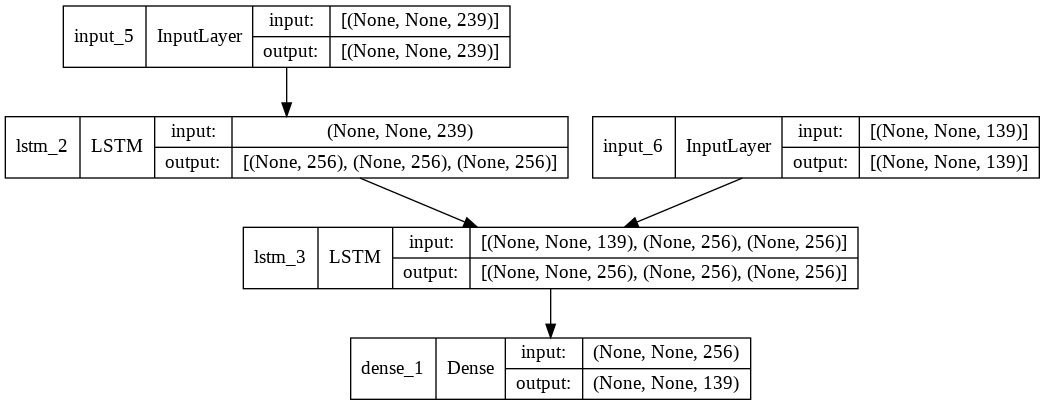

In [24]:
# Sources:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# http://www.adeveloperdiary.com/data-science/deep-learning/nlp/machine-translation-recurrent-neural-network-pytorch/
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
# https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639
# https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils.vis_utils import plot_model

batch_size = 64
epochs = 50
hidden_dim = 256

# Layer Dimensions
encoder_input_layer = Input(shape=(None, num_encoder_tokens))
decoder_input_layer = Input(shape=(None, num_decoder_tokens))

# Encoder LSTM
encoder_LSTM = LSTM(hidden_dim, return_state=True)
_, state_h, state_c = encoder_LSTM(encoder_input_layer)
encoder_states = [state_h, state_c]

# Decoder LSTM
decoder_LSTM = LSTM(hidden_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_input_layer, initial_state=encoder_states)
# Dense layer to predict output sequence
decoder_dense = Dense(num_decoder_tokens, activation="softmax")  # softmax activation function
decoder_outputs = decoder_dense(decoder_outputs)

# Model 
model = Model([encoder_input_layer, decoder_input_layer], decoder_outputs)
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)  # Plot model


### Training the Model

Epoch 1/50
704/704 [==============================] - 36s 45ms/step - loss: 0.9414 - accuracy: 0.7356 - val_loss: 0.8169 - val_accuracy: 0.7579
Epoch 2/50
704/704 [==============================] - 30s 43ms/step - loss: 0.7886 - accuracy: 0.7651 - val_loss: 0.7757 - val_accuracy: 0.7701
Epoch 3/50
704/704 [==============================] - 30s 43ms/step - loss: 0.7616 - accuracy: 0.7732 - val_loss: 0.7584 - val_accuracy: 0.7747
Epoch 4/50
704/704 [==============================] - 30s 43ms/step - loss: 0.7611 - accuracy: 0.7750 - val_loss: 0.7468 - val_accuracy: 0.7789
Epoch 5/50
704/704 [==============================] - 30s 43ms/step - loss: 0.7305 - accuracy: 0.7821 - val_loss: 0.7282 - val_accuracy: 0.7842
Epoch 6/50
704/704 [==============================] - 30s 43ms/step - loss: 0.7142 - accuracy: 0.7868 - val_loss: 0.7136 - val_accuracy: 0.7887
Epoch 7/50
704/704 [==============================] - 30s 43ms/step - loss: 0.6989 - accuracy: 0.7911 - val_loss: 0.6990 - val_accuracy:

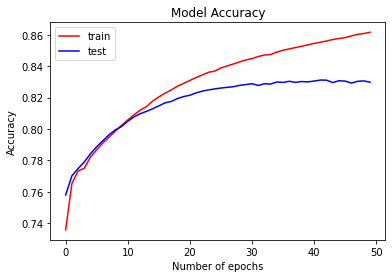

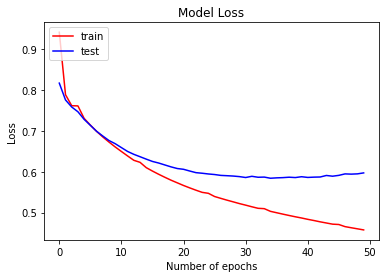

<Figure size 432x288 with 0 Axes>

In [25]:
# Train model
# Sources:
# https://colab.research.google.com/drive/1DBaHgsoPJCoj8SXAqNqQtKqAtwrUc4qS?usp=sharing#scrollTo=AMB2lJaMG8uh
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
import matplotlib.pyplot as plt

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# Fit the model
history = model.fit([encoder_input_seq, decoder_input_seq], decoder_output_seq, batch_size=batch_size, epochs=epochs, validation_split=0.2,)

# Accuracy Plot
plt.plot(history.history['accuracy'], 'r-')
plt.plot(history.history['val_accuracy'], color='blue')
plt.title('Model Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy-graph.png')

# Loss Plot
plt.plot(history.history['loss'], 'r-')
plt.plot(history.history['val_loss'], color='blue')
plt.title('Model Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss-graph.png')


### Encoder and Decoder Models

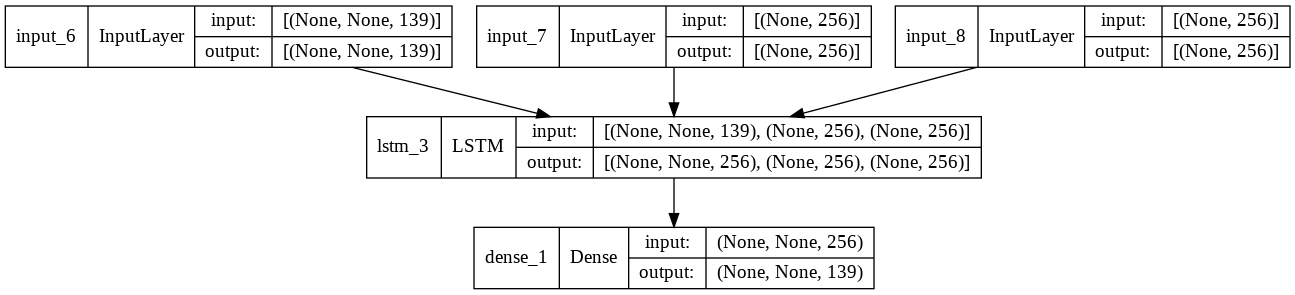

In [26]:
# Sources:
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
# https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/

# Encoder Model
encoder_model = Model(encoder_input_layer, encoder_states)

# Decoder Model
decoder_state_input_h = keras.Input(shape=(hidden_dim,))
decoder_state_input_c = keras.Input(shape=(hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h_dec, state_c_dec = decoder_LSTM(decoder_input_layer, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_input_layer] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Plot models
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True)
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True)

### Decode Sequence Method

In [27]:
# Sources:
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

def output_seq(input_seq):
    """ This method is used to predict the output of an input sequence. """
    # Encode input sequence
    encoder_pred = encoder_model.predict(input_seq)

    # Output sequence
    out_seq = np.zeros((1, 1, num_decoder_tokens))
    out_seq[0, 0, output_token_index["\t"]] = 1
    decoded_sequence = ""

    # Once a sequence has been decoded, go backwards to get the sequence
    reverse_seq = dict((i, char) for char, i in output_token_index.items())

    while True:  # Continue until stopping condition has been met
        # Get output tokens
        output_tokens, state_h, state_c = decoder_model.predict([out_seq] + encoder_pred)

        # Get token and then get the corresponding character
        tok_id = np.argmax(output_tokens[0, -1, :])
        char_id = reverse_seq[tok_id]
        decoded_sequence += char_id

        out_seq = np.zeros((1, 1, num_decoder_tokens))
        out_seq[0, 0, tok_id] = 1

        encoder_pred = [state_h, state_c]

        # If reached the start of sequence or gone past the length of the seq., then stop
        if char_id == "\n" or len(decoded_sequence) > max_decoder_seq:  # Stopping condition
            break

    return decoded_sequence

## Generate Sequence

In [28]:
# Sources:
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
# https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python

for seq_id in range(0, 50):
    # Getting input sequence
    input_seq = encoder_input_seq[seq_id : seq_id + 1]
    # Getting output sequence
    decoded_sentence = output_seq(input_seq)

    print("Input sequence:", input_characters[seq_id])
    print("Decoded sequence:", decoded_sentence[:-1])
    print("Complete sequence:", input_characters[seq_id] + '\033[1m' + decoded_sentence + '\033[0;0m')

Input sequence: the word anarchism is etymolog
Decoded sequence: y and the 
Complete sequence: the word anarchism is etymology and the 

Input sequence: rom the greek languagegreek wi
Decoded sequence: th the sou
Complete sequence: rom the greek languagegreek with the sou

Input sequence: pampampampampampampampampampam
Decoded sequence: pampmdasht
Complete sequence: pampampampampampampampampampampampmdasht

Input sequence:  quotwithout archons ruler chi
Decoded sequence: lescontine
Complete sequence:  quotwithout archons ruler chilescontine

Input sequence: t anarchism as a political phi
Decoded sequence: losophy a 
Complete sequence: t anarchism as a political philosophy a 

Input sequence:  the belief that rulers are un
Decoded sequence: ited state
Complete sequence:  the belief that rulers are united state

Input sequence: and should be abolished althou
Decoded sequence: gh the sea
Complete sequence: and should be abolished although the sea

Input sequence: re differing interpretati

Consulted sources have been included in their respective cells. \\
Additional Sources used to understand Seq2Seq models: \\
Stanford CS224N: NLP with Deep Learning | Winter 2019 | Lecture 8 – Translation, Seq2Seq, Attention  
Availiable: https://www.youtube.com/watch?v=XXtpJxZBa2c